In [2]:
import os
import argparse

from tqdm import tqdm_notebook

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
from model.GMVAE import *

In [3]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=1,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

In [59]:
def softplus(pre_vars):
    return np.log(1 + np.e ** pre_vars)

In [60]:
def save_mus_and_vars(gmvae, num_components):
    
    mus_s, vars_s = [], []

    for class_idx in range(num_components):
        
        zeros = torch.zeros((1, num_components))
        zeros[0][class_idx] = 1
        mus = gmvae.network.generative.y_mu(zeros.cuda()).detach().squeeze().cpu().numpy()
        vars = gmvae.network.generative.y_var(zeros.cuda()).detach().squeeze().cpu().numpy()

        mus_s.append(mus); vars_s.append(vars)

    mus_s, vars_s = np.array(mus_s), softplus(np.array(vars_s))
    
    assert mus_s.shape == (num_components, 64) == vars_s.shape
    
    with open(f'smba_{num_components}.json', 'w+') as json_f:
        json.dump({'mus_s':mus_s.tolist(), 'vars_s':vars_s.tolist()}, json_f)

In [116]:
comps_to_test = np.arange(2, 9).tolist() + [28, 48, 68, 108, 128]
comps_to_test

[2, 3, 4, 5, 6, 7, 8, 28, 48, 68, 108, 128]

In [117]:
for i in tqdm_notebook(comps_to_test):
    args.num_classes = i
    gmvae = GMVAE(args)
    gmvae.network.load_state_dict(torch.load(f'../smba_gmvae_{i}/smba_gmvae.pth'))
    save_mus_and_vars(gmvae, i)

## Compute distances

In [118]:
def kl_divergence(mu1, mu2, sigma_1, sigma_2):

    sigma_diag_1 = np.eye(sigma_1.shape[0]) * sigma_1
    sigma_diag_2 = np.eye(sigma_2.shape[0]) * sigma_2

    sigma_diag_2_inv = np.linalg.inv(sigma_diag_2)

    kl = 0.5 * (np.log(np.linalg.det(sigma_diag_2) / np.linalg.det(sigma_diag_2))
                - mu1.shape[0] + np.trace(np.matmul(sigma_diag_2_inv, sigma_diag_1))
                + np.matmul(np.matmul(np.transpose(mu2 - mu1), sigma_diag_2_inv), (mu2 - mu1))
                )

    return kl

In [178]:
min_ratios = []
max_ratios = []
os.chdir('.')

mean_radius = []

for num_components in tqdm_notebook(comps_to_test):
    
    with open(f'smba_{num_components}.json', 'r') as json_f:
        learned_params = json.load(json_f)
        mus_s, stds_s = np.array(learned_params['mus_s']), np.array(learned_params['vars_s']) ** 0.5
        
    klds = []
    spreads = []
            
    for i in range(num_components):
        for j in range(num_components):
            if (j > i):
                klds.append(np.linalg.norm(mus_s[i] - mus_s[j]))
#                 klds.append(
#                     np.mean(
#                         np.abs(mus_s[i] - mus_s[j]) / ((stds_s[i] + stds_s[j]) * 0.5)
#                     )
#                 )
#                 klds.append(kl_divergence(mus_s[i], mus_s[j], stds_s[i], stds_s[j]))

    mean_radius.append(stds_s.max())
                
    min_ratios.append(np.min(klds))
    max_ratios.append(np.max(klds))

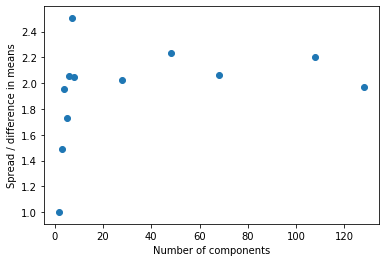

In [179]:
plt.scatter(comps_to_test, np.array(max_ratios) / np.min(max_ratios))
plt.ylabel('Spread / difference in means'); plt.xlabel('Number of components')
plt.show()

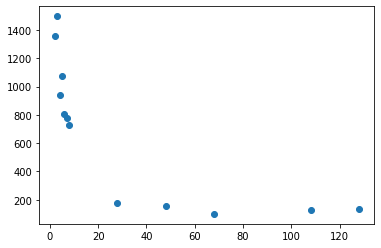

In [182]:
plt.scatter(comps_to_test, np.array(min_ratios) / np.min(min_ratios) * 100)
plt.show()

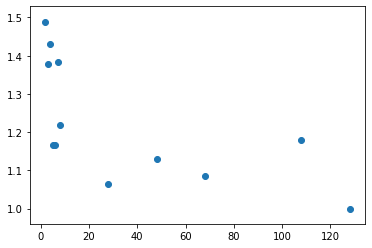

In [183]:
plt.scatter(comps_to_test, mean_radius / np.min(mean_radius))
plt.show()